In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))


# [0.10165, 0.25, 0.35, 0.45, 0.575, 0.725, 0.9][1.65, 2.5, 3.5]
# MUV = np.arange(-28, -8.8, 0.2)
Ms = np.logspace(7, 12, 50)

# blob 1: the LF. Give it a name, and the function needed to calculate it.
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('bins', Ms)]
blob_f1 = ['StellarMassFunction']

# # blob 2: the SFE. Same deal.
# blob_n2 = ['fstar']
# blob_i2 = [('z', redshifts), ('Mh', Mh)]
# blob_f2 = ['fstar']
# print(redshifts)

In [3]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [4]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)
base_pars.update({'progress_bar': True, 'debug':True})


# This is important!
# base_pars['pop_calib_lum'] = None

In [5]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]', 
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(0, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0.001, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, .9),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, -0.01),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(0, 2),  'pq_func_par2[3]')

In [6]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

In [7]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'

# print(fitter_smf.data)

In [8]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [9]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [10]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
# 2-D blobs can get large, so this allows us to just download a single
# snapshot or two if we'd like (useful if running on remote machine)
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 80

# fitter.jitter = [0.1] * len(fitter.parameters)
fitter.jitter = [0.1, 0.1, 0.01, 0.05, 0.1, 0.1, 0.8, 0.1]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops

# Fixing position of walker 53 (parameter pq_func_par2[2])
# Moved from 0.0005943005092247655 to -0.36041202790644555
# Fixing position of walker 0 (parameter pq_func_par2[3])
# Moved from -0.03321724913016866 to 0.11515102369375517
# Fixing position of walker 1 (parameter pq_func_par2[3])
# Moved from -0.0577003662436182 to 0.028297173763539712
# Fixing position of walker 3 (parameter pq_func_par2[3])
# Moved from -0.1134455862733073 to 0.037542439642751765
# Fixing position of walker 4 (parameter pq_func_par2[3])
# Moved from -0.042291144005318665 to 0.0008394047067461739
# Fixing position of walker 5 (parameter pq_func_par2[3])
# Moved from -0.1677686921952878 to 0.015197225374564749
# Fixing position of walker 6 (parameter pq_func_par2[3])
# Moved from -0.054070236604025004 to 0.04622571414110817
# Fixing position of walker 8 (parameter pq_func_par2[3])
# Moved from -0.13962317992824383 to 0.028297173763539712
# Fixing position of walker 9 (parameter pq_func_par2[3])
# Moved from -

In [ ]:
# Run the thing
fitter.run('test_smfcal', burn=10, steps=60, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Tue Jun 23 15:34:04 2020
# Wrote test_smfcal.burn.dd0000.facc.pkl: Tue Jun 23 15:41:02 2020
# Wrote test_smfcal.burn.dd0001.facc.pkl: Tue Jun 23 15:44:14 2020
# Wrote test_smfcal.burn.dd0002.facc.pkl: Tue Jun 23 15:47:17 2020
# Wrote test_smfcal.burn.dd0003.facc.pkl: Tue Jun 23 15:52:32 2020
# Wrote test_smfcal.burn.dd0004.facc.pkl: Tue Jun 23 15:58:17 2020
# Wrote test_smfcal.burn.dd0005.facc.pkl: Tue Jun 23 16:04:51 2020
# Wrote test_smfcal.burn.dd0006.facc.pkl: Tue Jun 23 16:08:00 2020
# Wrote test_smfcal.burn.dd0007.facc.pkl: Tue Jun 23 16:10:27 2020
# Wrote test_smfcal.burn.dd0008.facc.pkl: Tue Jun 23 16:12:32 2020
# Wrote test_smfcal.burn.dd0009.facc.pkl: Tue Jun 23 16:14:54 2020
# Burn-in complete in 2.45e+03 seconds.
# Fixing position of walker 2 (parameter pq_func_par0[2])
# Moved from -0.015888011672354395 to 0.02459463556292981
# Fixing position of walker 15 (parameter pq_func_par0[2])
# Moved from -0.01437913

In [47]:
anl = ares.analysis.ModelSet('test_smfcal')

labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels
# anl.custom_labels


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : test_smfcal                                                                            ####
#### N-d         : 8                                                                                      ####


# Loading test_smfcal.dd*.chain.pkl...
# Loaded test_smfcal.dd*.chain.pkl in 0.24 s.
# Loaded test_smfcal.dd0000.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0001.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0002.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0003.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0004.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0005.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0006.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0007.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0008.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0009.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0010.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0011.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0012.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0013.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0014.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0015.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0016.blob_2d.galaxy_smf.pkl
# Loaded test_smfcal.dd0017.blob_2d.galaxy_smf.p

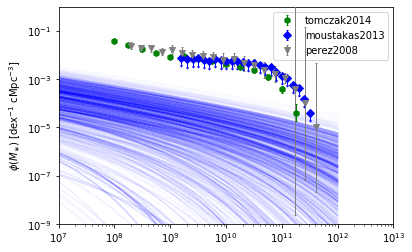

In [11]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2)

ax.set_ylim(1e-9, 1)
ax.legend()
pl.show()

In [12]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.451358e+00
pq_func_par2[0]: -7.016875e-02
pq_func_par0[1]: 3.683092e-02
pq_func_par2[1]: -9.213093e-01
pq_func_par0[2]: 6.185997e-01
pq_func_par2[2]: -3.834686e-01
pq_func_par0[3]: 1.287369e+01
pq_func_par2[3]: 8.813887e-01


# Loading test_smfcal.dd*.chain.pkl...
# Loaded test_smfcal.dd*.chain.pkl in 0.051 s.
0 of 2560 chain elements ignored because of chain links with inf's/nan's.


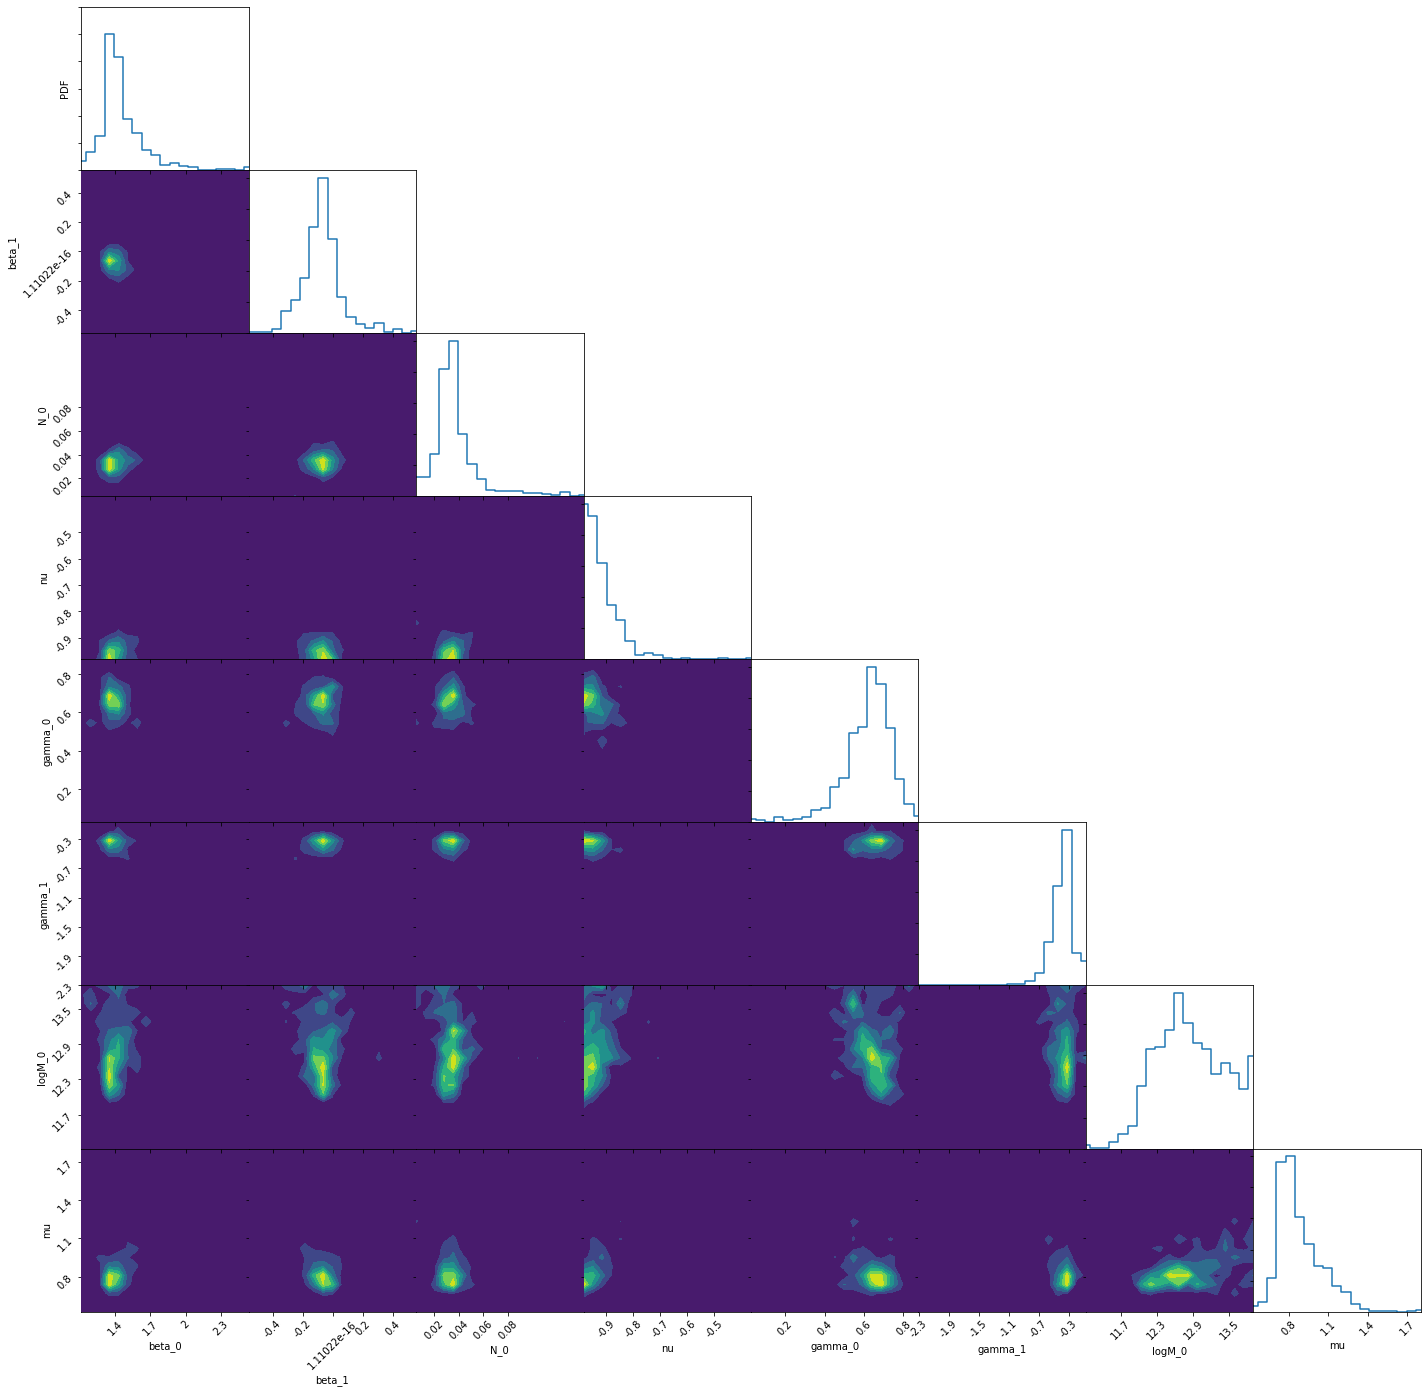

In [48]:

anl.TrianglePlot(pars=params)#, #ivar=[z])#, None, None, None, None, None, None], \
#                  label_panels=params) #, #samples='all', color='b', alpha=0.01)

In [ ]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [ ]:
anl.max_likelihood_parameters()

In [14]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.451358e+00
pq_func_par2[0]: -7.016875e-02
pq_func_par0[1]: 3.683092e-02
pq_func_par2[1]: -9.213093e-01
pq_func_par0[2]: 6.185997e-01
pq_func_par2[2]: -3.834686e-01
pq_func_par0[3]: 1.287369e+01
pq_func_par2[3]: 8.813887e-01


In [16]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [17]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(1.6640126281386118, array([-0.06770039,  0.34476719]))
(-0.24490092621093906, array([ 0.26939673, -0.06132102]))
(0.028634065268826017, array([0.01850286, 0.00451497]))
(-0.8696781852259038, array([0.00549064, 0.10963379]))
(0.7726707402226215, array([-0.05014627,  0.25728312]))
(-0.39593736237880855, array([0.13388267, 0.11506996]))
(13.642767516165037, array([-0.09227849,  1.36917216]))
(1.3031583410435634, array([-0.24782115,  0.5660035 ]))


In [18]:
pars_best = ares.util.ParameterBundle("emma:model1")

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

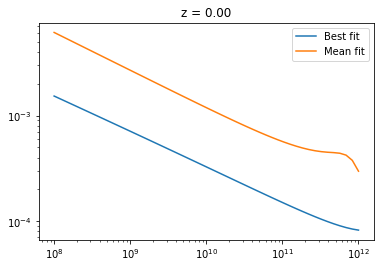

In [45]:
z = 0

Ms_short = np.logspace(8, 12, 50)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

obslf = ares.analysis.GalaxyPopulation()
# obslf.Plot(z=z, round_z=0.2)

pl.loglog(Ms_short, ls_best, label='Best fit')
pl.loglog(Ms_short, ls_mean, label='Mean fit')
pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-9, 1e2)
pl.show()